use device xpu
original


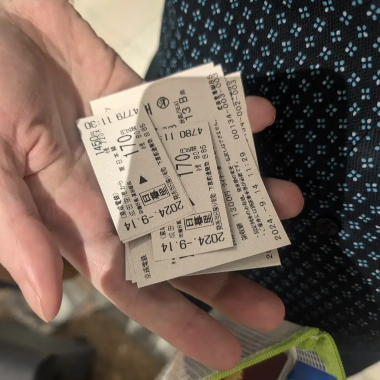

psf


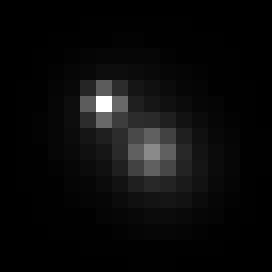

filtered


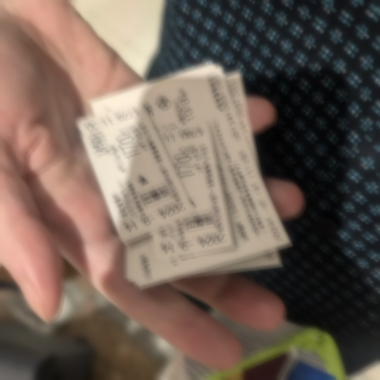

filtered, quantized & jpeg compression


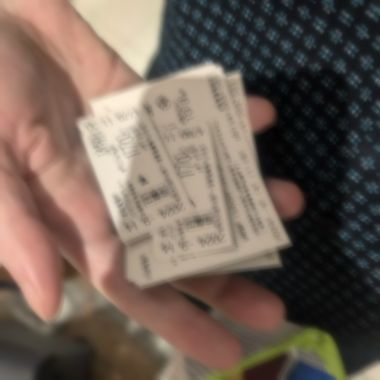

In [1]:
import PIL.Image as Image
import torchvision.transforms.functional as TF
import torchvision.transforms.v2.functional as TF2
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

device = 'cpu'
if torch.xpu.is_available():
    device = 'xpu'
elif torch.cuda.is_available():
    device = 'cuda'
print('use device', device)

frame_original = TF.to_tensor(Image.open('template.png').convert('RGBA')).to(device).unsqueeze_(0)

H, W = frame_original.size()[-2:]

print('original')
display(TF.to_pil_image(frame_original[0]))

FILTER_SIZE = 17
FILTER_SIGMA = 2

def gaussian_kernel(kernel_size, sigma, shift_x=0, shift_y=0):
    x = torch.arange(-(kernel_size // 2), kernel_size // 2 + 1, dtype=torch.float32)
    x_grid, y_grid = torch.meshgrid(x, x, indexing='ij')
    x_grid = x_grid + shift_x
    y_grid = y_grid + shift_y
    gaussian_2d = torch.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2))
    gaussian_2d = gaussian_2d / torch.sum(gaussian_2d)
    return gaussian_2d.view(1, 1, kernel_size, kernel_size)

psf = (
    gaussian_kernel(FILTER_SIZE, FILTER_SIGMA*2, 0, 0) +
    gaussian_kernel(FILTER_SIZE, FILTER_SIGMA, 1, 1) +
    gaussian_kernel(FILTER_SIZE, FILTER_SIGMA/2, -1, -1) +
    gaussian_kernel(FILTER_SIZE, FILTER_SIGMA/3, 2, 2) +
    gaussian_kernel(FILTER_SIZE, FILTER_SIGMA, -2, -2)
)
psf /= torch.sum(psf)
psf = psf.to(device)

print('psf')
display(TF.to_pil_image(F.interpolate(psf / psf.max(), scale_factor=16, mode='nearest')[0]))

def filter_psf(data, psf):
    s = data.size()
    data = data.reshape(s[0]*s[1], 1, s[2], s[3])
    p = psf.size(-1)//2
    data = F.pad(data, (p, p, p, p), 'reflect')
    data = F.conv2d(data, psf, None, 1)
    data = data.reshape(s[0], s[1], s[2], s[3])
    return data

frame_filtered = filter_psf(frame_original, psf)

print('filtered')
display(TF.to_pil_image(frame_filtered[0]))

# quantize to 8bit / simulate jpeg
frame_filtered = frame_filtered.mul(0xFF).to(torch.uint8)
frame_filtered = TF2.jpeg(frame_filtered[:,:3].cpu(), 80).to(device)
frame_filtered = F.pad(frame_filtered, (0,0,0,0,0,1), value=0xFF)
frame_filtered = frame_filtered.float().div(0xFF)

print('filtered, quantized & jpeg compression')
display(TF.to_pil_image(frame_filtered[0]))

richardson_lucy_deconvolution


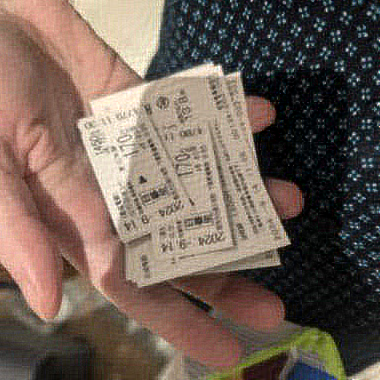

1150 ms 

gradient_decent_deconvolution mse_loss


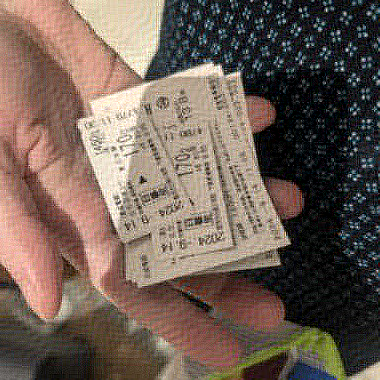

1718 ms 

gradient_decent_deconvolution l1_loss


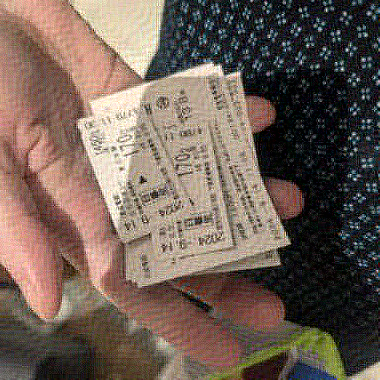

1509 ms 

gradient_decent_deconvolution mse_loss + vt_loss


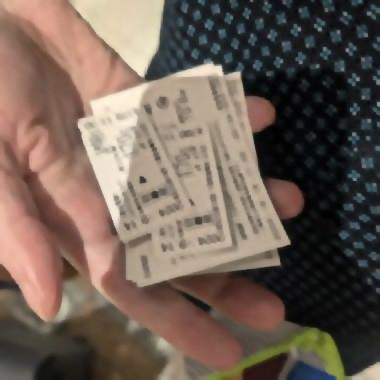

2528 ms 

gradient_decent_deconvolution l1_loss + vt_loss


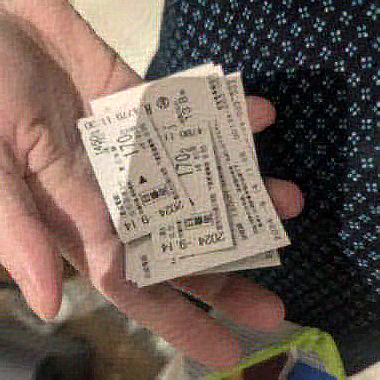

2502 ms 



In [2]:
def richardson_lucy_deconvolution(blurred_image, psf, num_iterations=8000, clip=True, eps=1e-12):
    blurred_image = blurred_image.detach()
    psf = psf.detach()

    psf_flipped = torch.flip(psf, [2, 3])

    estimated_image = blurred_image.clone()

    for _ in range(num_iterations):
        blurred_estimate = filter_psf(estimated_image, psf)
        ratio = blurred_image / (blurred_estimate + eps)
        correction = filter_psf(ratio, psf_flipped)
        estimated_image *= correction

        if clip:
            estimated_image.clamp_(0, 1)

        yield estimated_image.data

def gradient_decent_deconvolution(blurred_image, psf, num_iterations=8000, clip=True, criterion=None, optimizer=optim.Adam, **opt_params):
    blurred_image = blurred_image.detach()
    psf = psf.detach()

    if criterion is None:
        criterion = lambda x, y, z: F.l1_loss(y, z)

    estimated_image = blurred_image.clone()
    estimated_image = nn.Parameter(estimated_image)
    optimizer = optimizer([estimated_image], **opt_params)
    for _ in range(num_iterations):
        optimizer.zero_grad()
        blurred_estimate = filter_psf(estimated_image, psf)
        criterion(estimated_image, blurred_estimate, blurred_image).backward()
        optimizer.step()

        if clip:
            estimated_image.data.clamp_(0, 1)

        yield estimated_image.data

def total_variation_loss(img):
    diff_x = img[:, :, :, 1:] - img[:, :, :, :-1]
    diff_y = img[:, :, 1:, :] - img[:, :, :-1, :]
    tv_loss = torch.sum(torch.abs(diff_x)) + torch.sum(torch.abs(diff_y))
    return tv_loss / img.numel()

import time
ITERS = 200
LR = 1e-1
for m, f in (
    ('richardson_lucy_deconvolution',
       lambda: richardson_lucy_deconvolution(frame_filtered, psf, num_iterations=ITERS)),
    ('gradient_decent_deconvolution mse_loss',
        lambda: gradient_decent_deconvolution(frame_filtered, psf, num_iterations=ITERS, criterion=lambda x, y, z: F.mse_loss(y, z), lr=LR)),
    ('gradient_decent_deconvolution l1_loss',
        lambda: gradient_decent_deconvolution(frame_filtered, psf, num_iterations=ITERS, criterion=lambda x, y, z: F.l1_loss(y, z), lr=LR)),
    ('gradient_decent_deconvolution mse_loss + vt_loss',
        lambda: gradient_decent_deconvolution(frame_filtered, psf, num_iterations=ITERS, criterion=lambda x, y, z: F.mse_loss(y, z) + total_variation_loss(x) * 8e-3, lr=LR)),
    ('gradient_decent_deconvolution l1_loss + vt_loss',
        lambda: gradient_decent_deconvolution(frame_filtered, psf, num_iterations=ITERS, criterion=lambda x, y, z: F.l1_loss(y, z) + total_variation_loss(x) * 8e-3, lr=LR))
):
    print(m)
    u = None
    start = time.time()
    for frame_reconstructed in f():
        now  = time.time()
        v = TF.to_pil_image(frame_reconstructed[0])
        if u is None:
            u = display(v, display_id=True)
        else:
            if now-last < 0.125:
                continue
            u.update(v)
        last = now
    u.update(v)
    end = time.time()
    print(int((end-start)*1000),'ms \n')
